In [1]:
from transformers import T5Tokenizer, T5Model, T5EncoderModel
import re
import torch


tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_uniref50', do_lower_case=False)

model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

/scratch/users/anup/condaenv/envs/prot_model/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.5.layer.0.layer_norm.weight', 'decoder.block.19.layer.0.layer_norm.weight', 'decoder.block.23.layer.2.layer_norm.weight', 'decoder.block.17.layer.0.SelfAttention.v.weight', 'decoder.block.21.layer.0.SelfAttention.o.weight', 'decoder.block.2.layer.1.layer_norm.weight', 'decoder.block.9.layer.1.layer_norm.weight', 'decoder.block.14.layer.1.EncDecAttention.o.weight', 'decoder.block.16.layer.0.SelfAttention.q.weight', 'decoder.block.13.layer.1.EncDecAttention.v.weight', 'decoder.block.15.layer.0.layer_norm.weight', 'decoder.block.1.layer.0.SelfAttention.q.weight', 'decoder.block.0.layer.

In [18]:


'''sequences_Example = ["A E T C Z A O", "S K T Z P C A"]
#sequences_Example = ["A E T C Z A O"]

sequences_Example = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_Example]

ids = tokenizer.batch_encode_plus(sequences_Example, add_special_tokens=True, padding=True)

input_ids = torch.tensor(ids['input_ids'])
attention_mask = torch.tensor(ids['attention_mask'])

features = []
agg_features = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][:seq_len-1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

'''

In [46]:
from Bio import SeqIO

fasta_sequences = SeqIO.parse("spike_protein.fasta", "fasta")

In [55]:
i_seq = 0
sequences = []
for fasta in fasta_sequences:
    
    # name, seq = fasta.id.split(' ')[0], list(" ".join(str(fasta.seq)))
    name, seq = fasta.id.split(" ")[0], str(fasta.seq)
    print(name)
    # delete * signs prodigal puts at the end of sequence
    seq = re.sub("\*", "", seq)
    sequences.append(" ".join(seq))
    name = re.sub("\|", "_", name)
    name = re.sub("\/", "_", name)
    i_seq += 1
    if i_seq == 5:
        break

Spike|hCoV-19/Denmark/DCGC-34065/2021|2021-01-11|EPI_ISL_871075|Original|hCoV-19^^Syddanmark|Human|Department
Spike|hCoV-19/Denmark/DCGC-10584/2020|2020-11-02|EPI_ISL_670069|Original|hCoV-19^^Hovedstaden|Human|Department
Spike|hCoV-19/USA/NY-WCM-0639-2-P/2020|2020-03-15|EPI_ISL_855302|Original|hCoV-19^^New
Spike|hCoV-19/France/ARA-72111/2020|2020-09-14|EPI_ISL_692750|Original|hCoV-19^^Auvergne-Rh\u00f4ne-Alpes|Human|CNR
Spike|hCoV-19/Denmark/DCGC-16318/2020|2020-11-16|EPI_ISL_714700|Original|hCoV-19^^Sjaelland|Human|Department


In [56]:
len(sequences)

5

In [59]:
# map rarely occured amino acids (U,Z,O,B) to (X)
sequences = [re.sub(r"[UZOJB]", "X", sequence) for sequence in sequences]
# Tokenize, encode sequences and load it into the GPU if possibile
ids = tokenizer.batch_encode_plus(
    sequences, add_special_tokens=True, padding=True
)
input_ids = torch.tensor(ids["input_ids"])
attention_mask = torch.tensor(ids["attention_mask"])

with torch.no_grad():
    embedding = model(input_ids=input_ids, attention_mask=attention_mask)
embedding = embedding.last_hidden_state.cpu().numpy()

In [60]:
features = []
agg_features = []
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][: seq_len - 1]
    agg_features.append(np.mean(seq_emd, axis=0))
    features.append(seq_emd)

In [61]:
agg_features

[array([-0.01594155,  0.04091743,  0.01029942, ..., -0.00084221,
        -0.00845257, -0.04973286], dtype=float32),
 array([-0.01604992,  0.04088077,  0.01024161, ..., -0.00081691,
        -0.00810099, -0.04953508], dtype=float32),
 array([-0.01604992,  0.04088077,  0.01024161, ..., -0.00081691,
        -0.00810099, -0.04953508], dtype=float32),
 array([-0.01607851,  0.04084112,  0.01020826, ..., -0.00084459,
        -0.0080862 , -0.04918609], dtype=float32),
 array([-0.0159334 ,  0.04081071,  0.0104409 , ..., -0.00079796,
        -0.00778823, -0.04944877], dtype=float32)]

In [36]:
agg_features

[array([ 0.24435775, -0.05138602, -0.21840297, ...,  0.06471463,
         0.09767735,  0.01554805], dtype=float32),
 array([ 0.17198493, -0.05616444, -0.16014837, ...,  0.0517193 ,
         0.03530576, -0.00154973], dtype=float32)]

In [37]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

X = np.array(agg_features) #np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]]) #np.array(features) #np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X.shape

(2, 1024)

In [38]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=1).fit_transform(X)
X_embedded

array([[-1286.0967, -3513.6763],
       [ 1286.0968,  3513.676 ]], dtype=float32)

In [32]:
z = X_embedded

<ipython-input-34-9d12219f052d>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="comp-1", y="comp-2",


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

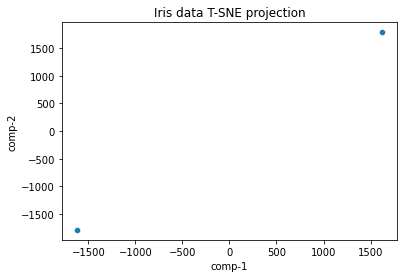

In [34]:
df = pd.DataFrame()
#df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2",
                palette=sns.color_palette("hls", 3),
                data=df).set(title="Iris data T-SNE projection") 

NameError: name 'y' is not defined